Copyright (c) 2021 Juergen Koefinger, Max Planck Institute of Biophysics, Frankfurt am Main, Germany

# Requirements

**To run the notebook**, you have to install the BioEn software for efficient ensemble refinement by reweighting (https://github.com/bio-phys/bioen) and binless WHAM (https://github.com/bio-phys/binless-wham).

# Preliminaries

In [1]:
import matplotlib.pyplot as plt
from numba import jit
import scipy.stats, copy, matplotlib
from importlib import reload
import numpy as np
import binless_wham as WHAM
import bioen 
from bioen.analyze import utils
from bioen import optimize
import polymer_model as pm
import BioFF_von_Mises as bioff

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rc('axes', labelsize=16) 

In [2]:
#%config Completer.use_jedi = False #activates TAB completion

In [3]:
img_path = "./img/" # Output path for plot. Generate it by hand.
ipath = "./data/"  # Input path for reference simulation. Generate it by hand.

# Initialization

## Set the value of confidence parameter $\theta$

In [4]:
theta = 1.

## Input

In [47]:
idx_labels = (0, 49) # indices of bead pair which we use for label distance
N_beads=100 # number of beads

### Read in synthetic data for experiment

In [6]:
kappa_exp = 10 # experimental kappa value
sample_info={}
sample_info['n_run']=10000
sample_info['n_sample']=-1  # legacy

In [7]:
cfx_exp, phi_mat_exp, energies_exp, dists_exp, dists_stats_exp = pm.init_from_single_sim(kappa_exp, N_beads, 0, 0, sample_info, idx_labels, ipath, pref="vonMises_")

In [8]:
exp={}
exp['mean'] = dists_exp['label'][kappa_exp].mean()
exp['stderr'] = 1 # error
Y = np.matrix(exp['mean']) # measured ensemble average
YTilde = Y/exp['stderr'] 
print(Y)

[[33.07652645]]


### Read in reference simulation

In [9]:
kappa_ref = 20  # kappa of reference simulation
N_beads=100
sample_info={}
sample_info['n_run']=10000
sample_info['n_sample']=-1  # legacy 

In [10]:
ensemble_size = 4000

In [11]:
cfx_dict, phi_mats, energies, dists, dists_stats = pm.init_from_single_sim(kappa_ref, N_beads, 0, 0, sample_info, idx_labels, ipath, pref="vonMises_", N_configs=ensemble_size)

In [12]:
ensemble_size = len(cfx_dict[kappa_ref])

In [13]:
print("ensemble size = ", ensemble_size)

ensemble size =  4000


## Generate sub-folder for output

In [16]:
# generate sub-directory for plots
img_sub="/kappa_exp%3.1f_kappa_ref%3.1f/" % (kappa_exp, kappa_ref )
print(img_sub)
import os
try:
    os.mkdir(img_path+"/"+img_sub)
except:
    print("Exists")

/kappa_exp10.0_kappa_ref20.0/
Exists


# BioFF-by-reweighting

## Initial optimization by reweighting

In [27]:
Y = dists_stats_exp['label'][kappa_exp]['mean'] # measured ensemble averaged observable
print("Y = %4.3f" % Y)
stderr = 1
YTilde = Y/stderr
y = dists['label'][kappa_ref]
N_config = len(y)
yTilde = y/stderr

Y = 33.077


In [28]:
w0 = np.ones(N_config)/float(N_config)
y_mean =  (w0*y).sum()
print ("y_mean = %4.3f" % y_mean)

y_mean = 40.078


### Optimize

In [29]:
kappa_sims=list(phi_mats.keys())
kappa_sims.sort()
all_phi_mats = pm.hstack_dict(phi_mats, kappa_sims)
all_u_refs = pm.von_Mises_energy(all_phi_mats, kappa_ref)

In [30]:
N_configs = len(all_u_refs)

In [31]:
w0 =np.ones(N_configs)/float(N_configs)  # reference weights

In [32]:
kappa_init = kappa_ref
res = scipy.optimize.minimize(bioff.objective_function, kappa_init, args= (w0, all_phi_mats, yTilde, YTilde,  all_u_refs, theta), method="Nelder-Mead")

In [33]:
kappa_new = res['x'][0] # optimal value for kappa from reference simulation alone

## Iterate until convergence

In [34]:
n_bins = 50 # number of histogram bins for plotting
max_iterations = 10 # maximum number of BioFF iterations
kappas_optimization = [kappa_ref, kappa_new] # list of iteratively optimized kappa values

In [35]:
all_energies =  pm.hstack_dict(energies, kappa_sims)


iteration 1
kappa_sims [16.2763671875, 20]


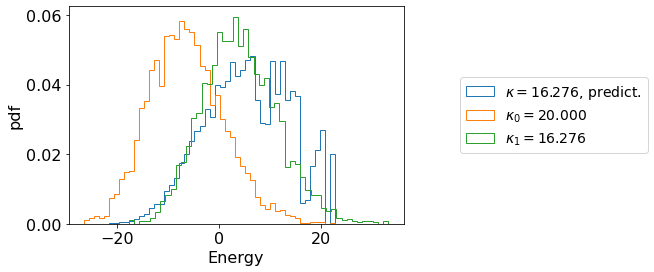

n_struct = 8000
Optimization terminated successfully.
         Current function value: 43724.671810
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


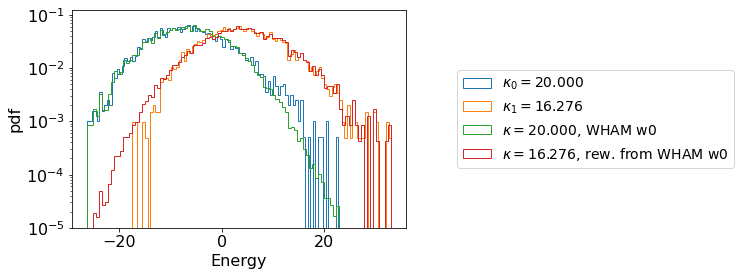

kappa_new =  13.4180

iteration 2
kappa_sims [13.417969280481334, 16.2763671875, 20]


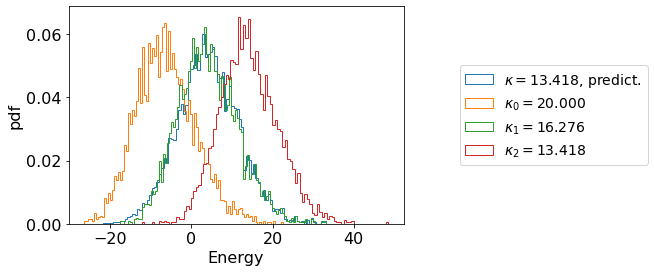

n_struct = 12000
Optimization terminated successfully.
         Current function value: -7988.516615
         Iterations: 10
         Function evaluations: 16
         Gradient evaluations: 16


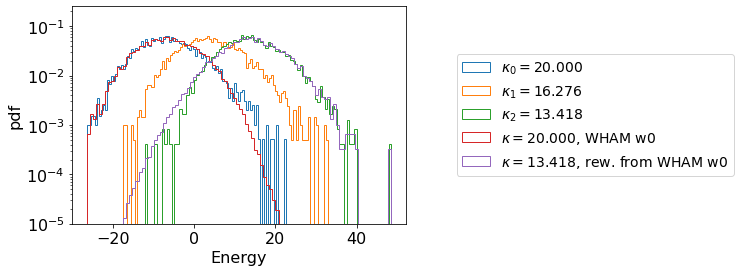

kappa_new =  12.9079

iteration 3
kappa_sims [12.90791610250991, 13.417969280481334, 16.2763671875, 20]


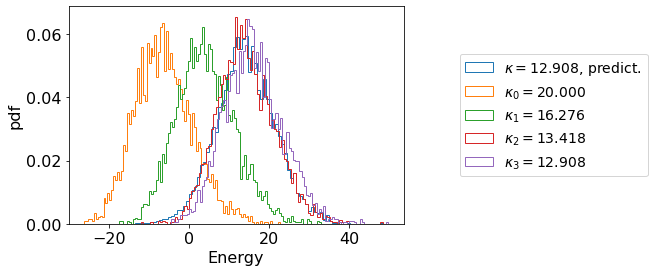

n_struct = 16000
         Current function value: -50829.156908
         Iterations: 10
         Function evaluations: 53
         Gradient evaluations: 41


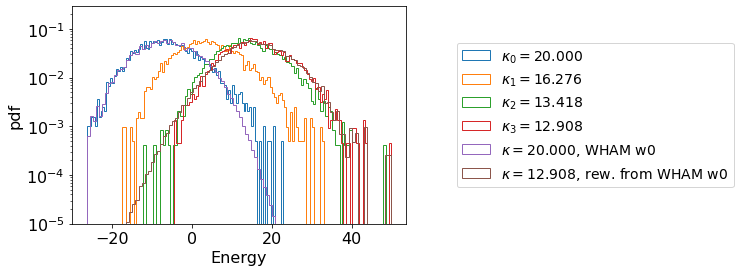

kappa_new =  12.8629


In [36]:
all_u = pm.von_Mises_energy(all_phi_mats, kappa_new)
w_new = bioff.reweighting(all_u, all_u_refs, w0)
#w_predicted = bioff.von_Mises_weights(all_phi_mats, kappa_new,  all_u_refs, w0)
kappa_old = kappa_new
n_converged = 0 # Counter. Increased if two kappa values are within threshold.
n_iterations = 0 # Counter. 
is_converged = False
while is_converged == False and (n_iterations+1) <= max_iterations:
    n_iterations += 1
    print()
    print("iteration %d" % n_iterations)
    

    plt.hist(all_energies, weights=w_new, density=True, bins=n_bins,  histtype='step', label=r"$\kappa = %4.3f$, predict." % kappa_new)
    # run simulation for newly optimized kappa value and calculate distances and energies
    configs_vonMises = pm.generate_vonMises_configs(ensemble_size, N_beads, kappa_new, mu=0)
    cfx_dict[kappa_new]=configs_vonMises
    phi_mats[kappa_new] = pm.get_phi_matrix(cfx_dict[kappa_new])
    pm.update_energies(phi_mats, [kappa_new], energies)
    pm.update_dists(cfx_dict, [kappa_new], idx_labels[0], idx_labels[1], 'label', dists)
    pm.update_dists(cfx_dict, [kappa_new], 0, N_beads-1, 'e2e', dists)
    pm.update_dist_stats(dists, [kappa_new], dists_stats)

    kappa_sims = list(cfx_dict.keys())
    kappa_sims.sort()
    print("kappa_sims", kappa_sims)
    
    # energies and distances for pool of simulations
    all_energies =  pm.hstack_dict(energies, kappa_sims) 
    y = pm.hstack_dict(dists['label'], kappa_sims)
    yTilde = y/stderr
    all_phi_mats = pm.hstack_dict(phi_mats, kappa_sims)
    all_u_refs = pm.von_Mises_energy(all_phi_mats, kappa_ref)
    
    
    ####################
    # plotting
    for ik,k in enumerate(energies):
        plt.hist(energies[k], density=True, bins=n_bins,  histtype='step', label=r"$\kappa_%d = %4.3f$" % (ik,k))
    plt.xlabel("Energy")
    plt.ylabel("pdf")
    plt.legend(fontsize=14, loc='center right', bbox_to_anchor=(1.75,0.5))
    plt.show()
    ####################
    
    # Perform WHAM for updated pool of simulations to obtaine reference ensemble
    nj, n_struct = bioff.set_nj(cfx_dict)
    print("n_struct =", n_struct)
    n_bias = len(kappa_sims)
    wkj_new= bioff.get_wkj(nj, kappa_sims, phi_mats, kappa_ref)
    w_wham_new, sig_wham_new, gj_new = WHAM.run_wham_bfgs_structure_weights(nj, wkj_new, norm_weights=True, beta = 1, Ij=np.ones(n_bias)*1, Ij_kinj = np.ones(n_struct))
    w0=w_wham_new
    all_u = pm.von_Mises_energy(all_phi_mats, kappa_new)
    w_new = bioff.reweighting(all_u, all_u_refs, w0)
    #w_new = bioff.von_Mises_weights(all_phi_mats, kappa_new, all_u_refs, w0)
    
    ####################
    # plotting
    n_bins = 100
    for ik, k in enumerate(energies):
        plt.hist(energies[k], density=True, bins=n_bins,  histtype='step', label=r"$\kappa_%d = %4.3f$" % (ik, k))
    plt.hist(all_energies, weights=w0, density=True, bins=n_bins,  histtype='step', label=r"$\kappa = %4.3f$, WHAM w0" % kappa_ref)
    plt.hist(all_energies, weights=w_new, density=True, bins=n_bins,  histtype='step', label=r"$\kappa = %4.3f$, rew. from WHAM w0" % k)
    plt.yscale('log')
    plt.ylim(bottom=1e-5)
    plt.xlabel("Energy")
    plt.ylabel("pdf")
    plt.legend(fontsize=14, loc='center right', bbox_to_anchor=(2,0.5))
    plt.show()
    ####################
    # optimize BioFF posterior
    kappa_init = kappa_new
    res = scipy.optimize.minimize(bioff.objective_function, kappa_init, 
                                  args= (w0, all_phi_mats, yTilde, YTilde, all_u_refs, theta), 
                                  method="Nelder-Mead")
    kappa_new = res['x'][0]
    print("kappa_new = %8.4f" % kappa_new)
    kappas_optimization.append(kappa_new)
    # check for convergence
    if bioff.convergence(kappa_old, kappa_new):
        n_converged+=1
    if n_converged==2:
        is_converged=True
    kappa_old = kappa_new

In [37]:
all_u = pm.von_Mises_energy(all_phi_mats, kappa_new)
w_new = bioff.reweighting(all_u, all_u_refs, w0)

# Plotting

## Convergence plots

energy_pdf_simulations_theta1.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


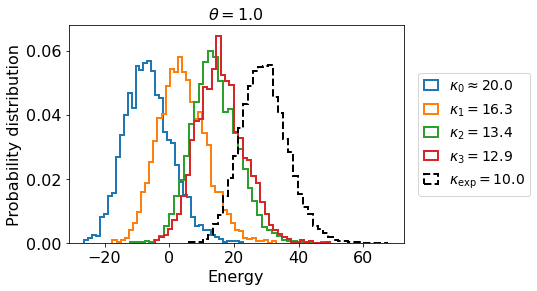

In [38]:
n_bins = 40
for i_iter, k in enumerate(energies):
    if i_iter == 0:
        tmp = r"$\kappa_%d \approx %.1f$" % (i_iter, k)
    else:
        tmp = r"$\kappa_%d = %.1f$" % (i_iter, k)
    plt.hist(energies[k], density=True, bins=n_bins,  histtype='step', label=tmp, lw=2)
plt.xlabel("Energy")
plt.ylabel("Probability distribution")
plt.title(r"$\theta = %3.1f$" % theta, size=16)
plt.hist(energies_exp[kappa_exp], ls='--', color='k', density=True, bins=n_bins,  histtype='step', label=r"$\kappa_\mathrm{exp}=%4.1f$" % (kappa_exp), lw=2)
#plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.5,1.8), ncol=2)
plt.legend(fontsize=14, loc='center right', bbox_to_anchor=(1.4,.5), ncol=1, handlelength=1)
q_save_fig=True
if q_save_fig:
    oname="energy_pdf_simulations_theta%3.2f"  % (theta)
    print(oname)
    for fmt in ['.pdf', '.eps']:
        plt.savefig(img_path+img_sub+oname+fmt, dpi=600,  bbox_inches='tight')
q_save_fig=False

kappas_theta1.00


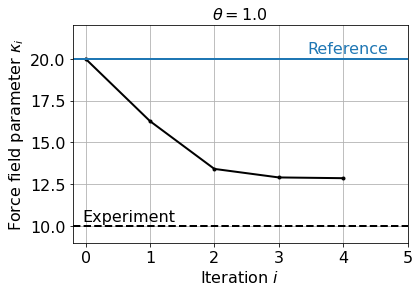

In [39]:
plt.plot(range(0,n_iterations+2), kappas_optimization, '.-', lw=2, c='k')
plt.axhline(kappa_exp, c='k', ls='--', label="Experiment", lw=2)
plt.axhline(kappa_ref,  label="Reference", lw=2)
plt.xlabel("Iteration $i$")
plt.ylabel("Force field parameter $\kappa_i$")
plt.gca().set_xticks(range(0, n_iterations+3))
plt.grid()
plt.title(r"$\theta = %3.1f$" % theta, size=16)
plt.ylim(kappa_exp-1, kappa_ref+2)
if kappa_exp==5:
    plt.text(0.02,0.07,"Experiment", fontsize=16, transform=plt.gca().transAxes)
    plt.text(0.7,0.91, "Reference", fontsize=16, transform=plt.gca().transAxes, color="C0")
elif kappa_exp==10:
    plt.text(0.03,0.1,"Experiment", fontsize=16, transform=plt.gca().transAxes)
    plt.text(0.7,0.87, "Reference", fontsize=16, transform=plt.gca().transAxes, color="C0")

q_save_fig=True
if q_save_fig:
    oname="kappas_theta%3.2f"  % (theta)
    print(oname)
    for fmt in ['.pdf', '.eps']:
        plt.savefig(img_path+img_sub+oname+fmt, dpi=600,  bbox_inches='tight')
q_save_fig=False

## Perform BioEn for pooled simulations for comparison

In [40]:
cfg = bioen.optimize.minimize.Parameters('lbfgs')

In [41]:
ev = 1 # set to on if you want to use all samples in the ensmble

# Initializing input for BioEn
N = len(y[::ev])
tmp = w0[::ev]
w0_WHAM=(np.matrix(tmp/tmp.sum())).T
print(w0_WHAM.shape)
G0 = optimize.log_weights.getGs(w0_WHAM)
y_bioen=np.matrix(y[::ev])


yTilde_bioen=y_bioen/exp['stderr']
print(yTilde_bioen.shape)
print(y_bioen.shape)
print(Y.shape)
GInit=G0.copy()
Y = np.matrix(exp['mean'])
YTilde = Y/exp['stderr']
print(Y)

(16000, 1)
(1, 16000)
(1, 16000)
()
[[33.07652645]]


In [42]:
wopt, yopt, gopt, fmin_init, fmin_final = optimize.log_weights.find_optimum(GInit, G0, y_bioen, yTilde_bioen, YTilde, theta, cfg)


fmin_initial 24.621963958626857
------------------------
LOGW -- Library L-BFGS/C
------------------------
time elapsed  0.15632295608520508
fmin_initial  =  24.621963958626857
fmin_final    =  0.33803009462754924


In [43]:
SKL_bioen= bioff.SKL(np.asarray(wopt.T[0]),w0)
print( "BioEn SKL = %5.3f" % SKL_bioen)

BioEn SKL = 0.335


In [44]:
w=np.asarray(wopt.T[0])
x =np.asarray(y_bioen)[0]
mean = (w*x).sum()
print(mean, Y)

33.15940700499381 [[33.07652645]]


## Plot distance distributions

In [45]:
SKL_bioff= bioff.SKL(w_new, w0)
print( "BioFF SKL = %5.3f" % SKL_bioff)

BioFF SKL = 5.847


label_pdf_theta1.00


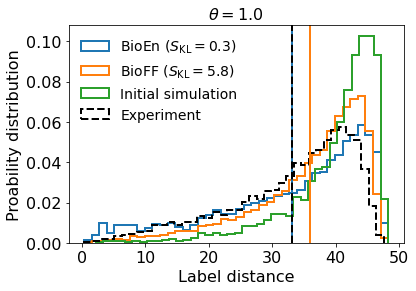

e2e_pdf_theta1.00


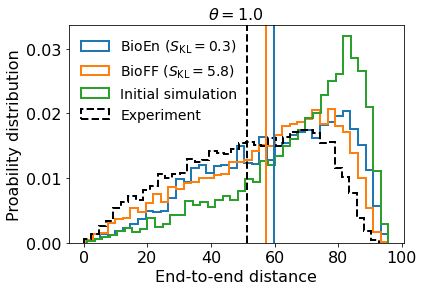

In [46]:
n_bins=40
lw=2

xlabels={}
xlabels['label'] = "Label distance"
xlabels['e2e'] = "End-to-end distance"
for key in ['label', 'e2e']:
    all_label_dists = pm.hstack_dict(dists[key], kappa_sims)
    bioen_mean = (all_label_dists*w).sum()
    bioff_mean = (all_label_dists*w_new).sum()
    plt.title(r"$\theta = %3.1f$" % theta, size=16)
    plt.hist(all_label_dists, weights = w, bins=n_bins, density=True, histtype='step', label="BioEn ($S_\mathrm{KL}=%3.1f$)" % SKL_bioen, lw=lw)
    plt.axvline(bioen_mean, color='C0', lw=lw)
    plt.hist(all_label_dists, weights = w_new, bins=n_bins, density=True, histtype='step', label="BioFF ($S_\mathrm{KL}=%3.1f$)" % SKL_bioff, lw=lw)
    plt.axvline(bioff_mean, color='C1', lw=lw)
    plt.hist(dists[key][kappa_ref],  bins=n_bins, histtype='step', density=True, label="Initial simulation", lw=lw)

    plt.hist(dists_exp[key][kappa_exp],  ls='--', color='k', bins=n_bins, density=True, histtype='step', label="Experiment", lw=lw)
    plt.axvline(dists_stats_exp[key][kappa_exp]['mean'], ls='--', color='k', lw=lw)

    plt.xlabel(xlabels[key])
    plt.ylabel("Proability distribution")
    plt.legend(fontsize=14, loc='upper left', ncol=1, frameon=False)
    q_save_fig=True
    if q_save_fig:
        oname="%s_pdf_theta%3.2f"  % (key, theta)
        print(oname)
        for fmt in ['.pdf', '.eps']:
            plt.savefig(img_path+img_sub+oname+fmt, dpi=600,  bbox_inches='tight')
    q_save_fig=False
    plt.show()